# Project 3 - Web APIs & Classification

## Problem Statement
---
Reddit is a collection of online discussion boards known as "subreddits", which cover a variety of topics. The goal of this project is to classify which subreddit a given post came from. As there are [over 1.5 million subreddits](http://redditmetrics.com/history) on reddit, we will be classifying posts from two subreddits, [/r/personalfinance](https://www.reddit.com/r/personalfinance/) and [/r/relationship_advice](https://www.reddit.com/r/relationship_advice/), to make the project manageable. The choice of these two subreddits is motivated by their text-heavy posts. We will be creating and comparing two models: a logistic regression and a multinomial naive Bayes classifier. Our results may be useful for any reddit user who is unsure which subreddit is the most appropriate to submit his new post, so that he can attract the most comments.

## Executive Summary
---
### Contents:
- [1. Data Collection](#1.-Data-Collection)
- [2. Data Cleaning and EDA](#2.-Data-Cleaning-and-EDA)
- [3. Pre-processing and Modeling](#3.-Pre-processing-and-Modeling)
- [4. Evaluation and Conceptual Understanding](#4.-Evaluation-and-Conceptual-Understanding)
- [5. Conclusion and Recommendations](#5.-Conclusion-and-Recommendations)

## 1. Data Collection
---

In [10]:
# Import libraries
import requests
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
sns.set(font_scale=1.5)

In [11]:
# Define function to scrape data
def scrape_data(urls, num_req):
    """
    Scrapes posts from subreddits.
    
    Parameters
    ----------
    urls : list[str]
        List of subreddit urls to scrape posts from.
    num_req : int
        Number of requests to hit reddit's API for each subreddit. 25 posts are returned per
        request(not counting stickied post). API returns max 1000 posts for each subreddit.
    
    Returns
    -------
    DataFrame
        A dataframe containing titles, texts and subreddit names of scraped posts.
    """
    # Get posts as list of dictionaries, each containing data on one post
    posts = []
    for url in tqdm(urls):
        after = None
        for i in tqdm(range(num_req)):
            if after == None:
                params = {}
            else:
                params = {'after': after}
            headers = {'User-agent': 'GA SG Bot 0.1'}
            res = requests.get(url, params=params, headers=headers)
            if res.status_code == 200:
                the_json = res.json()
                posts.extend(the_json['data']['children'])
                after = the_json['data']['after']
            else:
                print(res.status_code)
                break
            time.sleep(1)
    
    # Extract name id, title, text and subreddit origin from data and return in a DataFrame
    names, titles, texts, subreddits = [], [], [], []
    for i in range(len(posts)):
        names.append(posts[i]['data']['name'])
        titles.append(posts[i]['data']['title'])
        texts.append(posts[i]['data']['selftext'])
        subreddits.append(posts[i]['data']['subreddit'])
    return pd.DataFrame({'name': names, 'title': titles, 'text': texts, 'subreddit': subreddits})

In [3]:
# Scrape posts from subreddits
df = scrape_data([
    'https://www.reddit.com/r/personalfinance.json',
    'https://www.reddit.com/r/relationship_advice.json'
], num_req=50)

In [4]:
# Save results from scrape as csv
df.to_csv('../data/posts.csv', index=False)

## 2. Data Cleaning and EDA
---

In [39]:
# Read from csv if not scraping
df = pd.read_csv('../data/posts.csv')

In [40]:
# View first 5 rows
df.head()

,name,title,text,subreddit
0,t3_cdwsuf,New to /r/personalfinance? Have questions? Rea...,"# Welcome! Before making a post, please check...",personalfinance
1,t3_cgbtvt,Weekday Help and Victory Thread for the week o...,"### If you need help, please check the [PF Wik...",personalfinance
2,t3_ch9tcj,Claims are now being accepted for the 2017 Equ...,[Settlement website](https://www.equifaxbreach...,personalfinance
3,t3_chiqei,Are there any downside to putting a claim for ...,I just found out that we can put a claim in re...,personalfinance
4,t3_chpzag,$102k in credit card/consumer debt after deali...,"Hi all,\n\nSo yeah, we've learned our lesson t...",personalfinance


In [41]:
# View shape
df.shape

(2468, 4)

In [42]:
# Drop duplicate rows by comparing name ids
df.drop_duplicates(subset='name', inplace=True)

In [43]:
# Check for nulls
df.isnull().sum()

name          0
title         0
text         13
subreddit     0
dtype: int64

In [44]:
# Examine rows with null texts
df[df.text.isnull()]

,name,title,text,subreddit
5,t3_chjwh0,Why is gross income even considered when apply...,NaN,personalfinance
6,t3_chnu4z,If I have money in a high interest savings acc...,NaN,personalfinance
101,t3_choj3f,My siblings got their car broken into in our d...,NaN,personalfinance
128,t3_chnkpn,FSBO: As buyer use Redfin or no agent? [VA],NaN,personalfinance
530,t3_ch7i9c,Would like to buy a house but not sure based o...,NaN,personalfinance
734,t3_ch025o,Defined benefit + contribution plan annual max...,NaN,personalfinance
812,t3_cgy39w,Filed Wrong W2 on Taxes but Would Like to Buy ...,NaN,personalfinance
903,t3_cgua5t,I want to buy a house in about 9 months. Right...,NaN,personalfinance
916,t3_cgtmg2,Closed on a house a month ago and just had an ...,NaN,personalfinance
1812,t3_chk4un,So my bf is a white nationalist... What can I do,NaN,relationship_advice


Although not all posts have texts, their titles are complete and unique. We are going to keep these rows for modeling.

In [45]:
# Replace null texts with empty string
df.text.fillna(value='', inplace=True)

In [46]:
# View final shape
df.shape

(1918, 4)

In [47]:
# Put titles and texts into a single column.
df['text_feature'] = df['title'] + ' ' + df['text']

In [48]:
# Convert &amp;, &gt; and &lt; XML character entity references back to &, > and <
from xml.sax.saxutils import unescape
df.text_feature = df.text_feature.apply(unescape)

In [22]:
# Import library for generating word cloud
from wordcloud import WordCloud
from PIL import Image

# Define function to draw word cloud
def draw_wordcloud(text, plot_title=None, mask_img=None):
    """
    Generate and draw word cloud from text.
    
    Parameters
    ----------
    text : str
        Text to generate word cloud from.
    title : str
        Title to set on plot
    mask_img: str
        Path to image mask
    """
    mask = np.array(Image.open(mask_img))

    wordcloud = WordCloud(
        mask = mask,
        scale=7,
        max_words=1000,
        background_color='white',
        colormap='brg',
        contour_width=3,
        contour_color='steelblue',
        random_state=42
    ).generate(text)
    plt.figure(figsize=(14,14), facecolor='white')
    plt.imshow(wordcloud, interpolation="bilinear")
    if plot_title:
        plt.title(plot_title, fontsize=20, pad=50)
    plt.axis("off")
    plt.show()

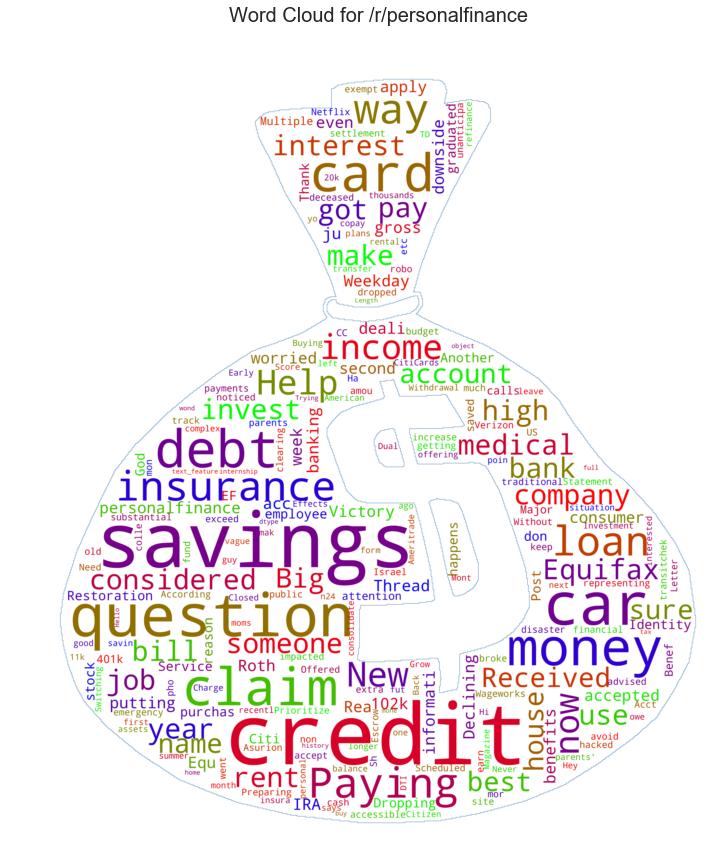

In [23]:
# Draw word cloud for /r/personalfinance
draw_wordcloud(
    str(df[df.subreddit=='personalfinance'].text_feature),
    plot_title='Word Cloud for /r/personalfinance',
    mask_img = '../images/money_mask.png'
)

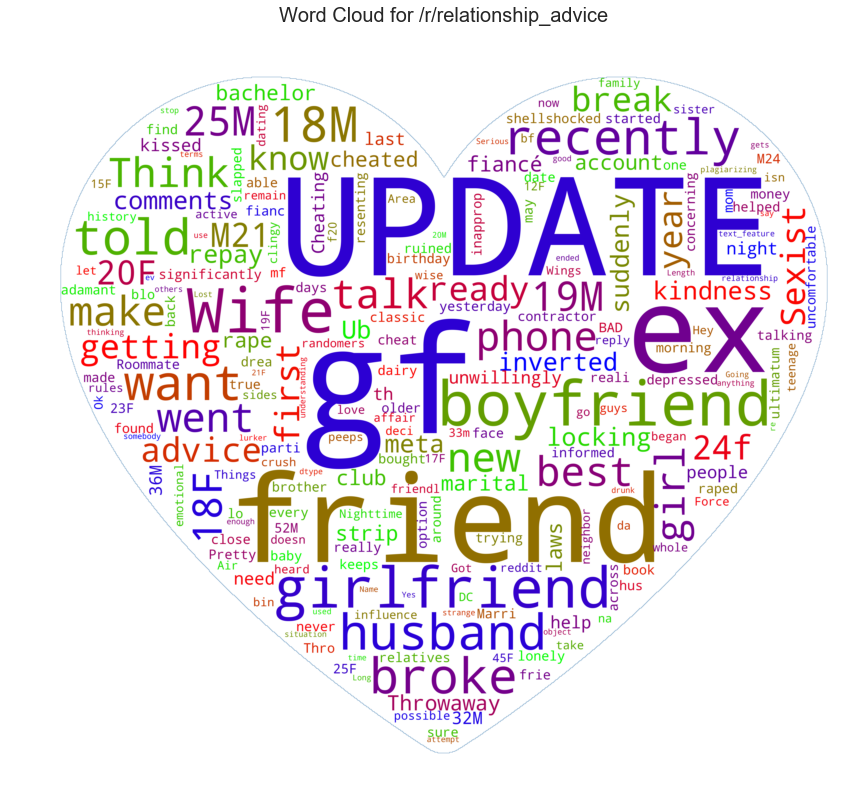

In [24]:
# Draw word cloud for /r/relationship_advice
draw_wordcloud(
    str(df[df.subreddit=='relationship_advice'].text_feature),
    plot_title='Word Cloud for /r/relationship_advice',
    mask_img = '../images/heart_mask.png'
)

In [49]:
# Instantiate CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

cvec = CountVectorizer(stop_words='english')
tfidf = TfidfVectorizer(stop_words='english')

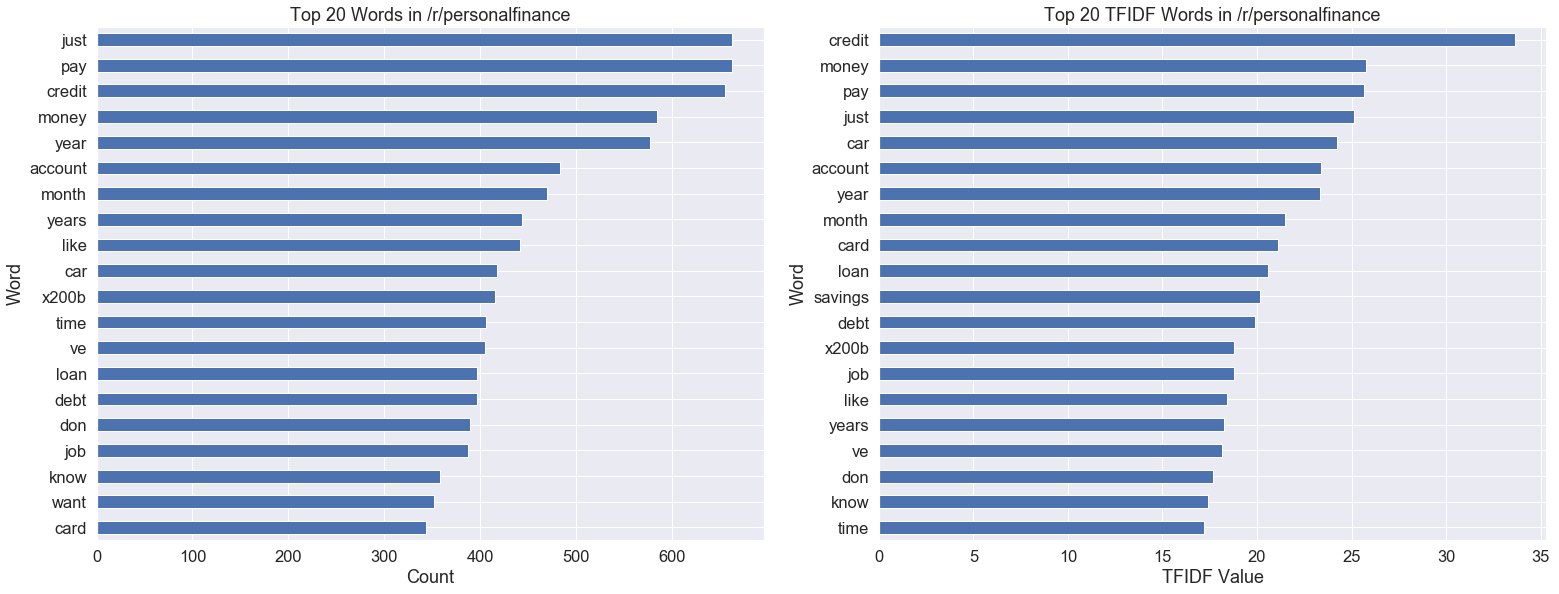

In [50]:
# Explore CountVectorizer token counts in /r/personalfinance
words_cvec_pf = pd.DataFrame(cvec.fit_transform(df[df.subreddit=='personalfinance'].text_feature).todense(),
                       columns=cvec.get_feature_names())
word_cvec_counts_pf = words_cvec_pf.sum(axis=0)

# Explore TfidfVectorizer token counts in /r/personalfinance
words_tfidf_pf = pd.DataFrame(tfidf.fit_transform(df[df.subreddit=='personalfinance'].text_feature).todense(),
                       columns=tfidf.get_feature_names())
word_counts_tfidf_pf = words_tfidf_pf.sum(axis=0)

# Plot top 20 words
plt.figure(figsize=(22,16), facecolor='white')

plt.subplot(2,2,1)
word_cvec_counts_pf.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 Words in /r/personalfinance')
plt.xlabel('Count')
plt.ylabel('Word')

plt.subplot(2,2,2)
word_counts_tfidf_pf.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 TFIDF Words in /r/personalfinance')
plt.xlabel('TFIDF Value')
plt.ylabel('Word')

plt.tight_layout()

The most frequent words are finance terms, such as credit, money, pay, account, etc.

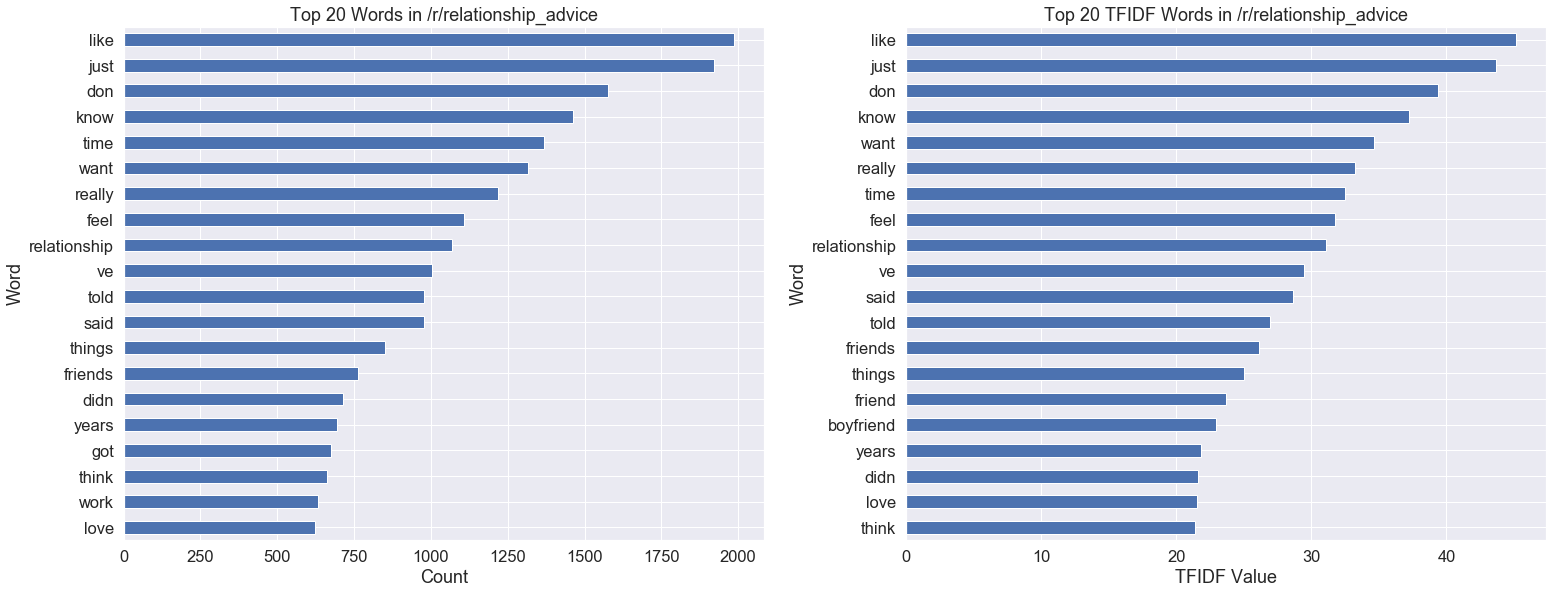

In [51]:
# Explore CountVectorizer token counts in /r/relationship_advice
words_cvec_ra = pd.DataFrame(cvec.fit_transform(df[df.subreddit=='relationship_advice'].text_feature).todense(),
                       columns=cvec.get_feature_names())
word_counts_cvec_ra = words_cvec_ra.sum(axis=0)

# Explore TfidfVectorizer token counts in /r/relationship_advice
words_tfidf_ra = pd.DataFrame(tfidf.fit_transform(df[df.subreddit=='relationship_advice'].text_feature).todense(),
                       columns=tfidf.get_feature_names())
word_counts_tfidf_ra = words_tfidf_ra.sum(axis=0)

# Plot top 20 words
plt.figure(figsize=(22,16), facecolor='white')

plt.subplot(2,2,1)
word_counts_cvec_ra.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 Words in /r/relationship_advice')
plt.xlabel('Count')
plt.ylabel('Word')

plt.subplot(2,2,2)
word_counts_tfidf_ra.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 TFIDF Words in /r/relationship_advice')
plt.xlabel('TFIDF Value')
plt.ylabel('Word')

plt.tight_layout()

Words that describe behavior are the most frequent, such as like, know, want, feel, etc.

## 3. Pre-processing and Modeling
---

In [52]:
# Engineer a feature to turn subreddit into a 1/0 column, where 1 indicates personalfinance
df['personalfinance'] = [1 if i == 'personalfinance' else 0 for i in df.subreddit]

In [53]:
# Split data into X and y
X = df.text_feature
y = df.personalfinance

In [54]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

In [55]:
# Fit and predict a logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

logr_model = make_pipeline(
    CountVectorizer(stop_words='english'),
    LogisticRegression(solver='lbfgs', multi_class='auto', random_state=42)
)
cv_scores = cross_val_score(logr_model, X_train, y_train, cv=5, scoring='roc_auc')
logr_model.fit(X_train, y_train)
y_pred = logr_model.predict(X_test)
print('Logistic regression model')
print('Train score: {}, Test score {}'.format(round(cv_scores.mean(), 4), round(roc_auc_score(y_test, y_pred), 4)))
print('Number of features: {}'.format(len(logr_model.named_steps.countvectorizer.get_feature_names())))

Logistic regression model
Train score: 0.9968, Test score 0.9752
Number of features: 12580


In [56]:
# Fit and predict a multinomial naive Bayes classifier (suits with discrete features)
from sklearn.naive_bayes import MultinomialNB

mnb_model = make_pipeline(
    CountVectorizer(stop_words='english'),
    MultinomialNB()
)
cv_scores = cross_val_score(mnb_model, X_train, y_train, cv=5, scoring='roc_auc')
mnb_model.fit(X_train, y_train)
y_pred = mnb_model.predict(X_test)
print('Multinomial naive Bayes classifier')
print('Train score: {}, Test score {}'.format(round(cv_scores.mean(), 4), round(roc_auc_score(y_test, y_pred), 4)))
print('Number of features: {}'.format(len(mnb_model.named_steps.countvectorizer.get_feature_names())))

Multinomial naive Bayes classifier
Train score: 0.9996, Test score 0.9873
Number of features: 12580


Our multinomial naive Bayes classifier performs better than our logistic regression model. We are going to use this classfier as our baseline and explore its parameters.

In [33]:
# Explore parameters for vectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf', None),
    ('mnb', MultinomialNB())
])

params = dict(
    cvec__stop_words = [None, 'english'],
    cvec__max_df = (0.5, 0.75, 1.0),
    cvec__ngram_range = [(1, 1), (2, 2)],
    tfidf = [None, TfidfTransformer(use_idf=True), TfidfTransformer(use_idf=False)]
)

gs = GridSearchCV(pipe, params, cv=5, scoring='roc_auc', iid=False, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Best params: {}".format(gs.best_params_))
print('Train score: {}, Test score {}'.format(round(gs.best_score_, 4), round(gs.best_estimator_.score(X_test, y_test), 4)))
print('Number of features: {}'.format(len(gs.best_estimator_.named_steps.cvec.get_feature_names())))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.1min finished


Best params: {'cvec__max_df': 0.5, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'tfidf': TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)}
Train score: 0.9998, Test score 0.9771
Number of features: 12578


Although our train score has improved, our test score has become worse - we have overfitted our model. Looking at our best parameters, if we are using tf-idf term weighting, frequent terms are already normalized, therefore we can set `max_df` unchanged at 1 to allow all features.

In [34]:
# Tune hyperparameter for multinomial naive Bayes
params = dict(
    cvec__stop_words = ['english'],
    tfidf = [TfidfTransformer(use_idf=True)],
    mnb__alpha = np.linspace(0.1, 1.0, 20)
)

gs = GridSearchCV(pipe, params, cv=5, scoring='roc_auc', iid=False, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Best params: {}".format(gs.best_params_))
print('Train score: {}, Test score {}'.format(round(gs.best_score_, 4), round(gs.best_estimator_.score(X_test, y_test), 4)))
print('Number of features: {}'.format(len(gs.best_estimator_.named_steps.cvec.get_feature_names())))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.2s finished


Best params: {'cvec__stop_words': 'english', 'mnb__alpha': 0.2894736842105263, 'tfidf': TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)}
Train score: 0.9999, Test score 0.9854
Number of features: 12580


Reducing the additive smoothing parameter improves our train score but at a slight penalty to the test score when compared to our baseline model. Our tf-idf transformation may have performed the regularization function in place of additive smoothing.

Since none of our tuned models performed significantly better than our baseline model, we will be using our baseline model as our production model.

In [111]:
# Dump model for production use on deployment
import joblib
joblib.dump(mnb_model, '../data/mnb_model.joblib')

['../data/mnb_model.joblib']

## 4. Evaluation and Conceptual Understanding
---

In [57]:
# Generate a confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = mnb_model.predict(X_test)

pd.DataFrame(confusion_matrix(y_test, y_pred),
            columns=['predict /r/relationship_advice', 'predict /r/personalfinance'],
            index=['actual /r/relationship_advice', 'actual /r/personalfinance'])

,predict /r/relationship_advice,predict /r/personalfinance
actual /r/relationship_advice,244,1
actual /r/personalfinance,5,230


In [58]:
# Examine some classification metrics 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
print('Precision: {}'.format(round(tp/(tp+fp),4)))
print('Recall: {}'.format(round(tp/(tp+fn),4)))
print('Specificity: {}'.format(round(tn/(tn+fp),4)))

Accuracy: 0.9875
Misclassification rate: 0.0125
Precision: 0.9957
Recall: 0.9787
Specificity: 0.9959


- Our model correctly predicts 98.75% of observations.
- Among posts that our model predicted to be in /r/personalfinance, we have 99.57% of them correctly classified.
- Among posts that are in /r/personalfinance, our model has 97.87% of them correctly classified.
- Among posts that are in /r/relationship_advice, our model has 99.59% of them correctly classified.

In [59]:
# Examine incorrectly classified posts
df_pred = pd.DataFrame({
    'X_test': X_test,
    'y_test': y_test,
    'y_pred': y_pred
})

# Posts incorrectly predicted to be in /r/relationship_advice
for i in df_pred[(df_pred.y_test - df_pred.y_pred) > 0]['X_test']:
    print(i)
    print('-'*20)

Hey please help I need money and Idk what to do Hi I’m 15years old about to turn 16 in two months and I need cash so I can move out of my house as soon as I get out of high school I don’t wanna explain in detail but my home life isn’t going well I’m new to reddit and idk if this is the right thread I don’t think it is but idk where else to post I can’t ask friends cause I don’t want to have to explain what is happening my parents won’t allow  me to get a job as cause that gives them more control over me but I need to get out of here is there any way that you know of that I can earn money or a reddit that might be more suited to my questions please anything I’m working on trying convince them but I doubt I will be successful please I need a way to earn cash I’m only have 3 more years of high school and I want to get out as soon as possible please anything can help any ideas or recommendations as to where to go would be so greatly appreciated thank you so much
--------------------
VBRO o

All of these posts have the word 'friend' in them, which could be a significant term that misclassified them in /r/relationship_advice.

In [60]:
# Posts incorrectly predicted to be in /r/personalfinance
for i in df_pred[(df_pred.y_test - df_pred.y_pred) < 0]['X_test']:
    print(i)
    print('-'*20)

How should I approach my girlfriend about contributing to monthly bills? As the title says, I'm wondering how to approach her on splitting bills. Currently I make roughly $37/h, and handle all bills for everything. My girlfriend (22 F), who got her first full time job, makes roughly $25/h, but also does PRN for a couple hours here and there where she makes anywhere from $30-40/hr. She has lived at my house for the past 6 months, for the most part she goes to her parents house for supper on sundays and stays there. I am under huge stress with bills. Between my mortgage, insruace, car payments, propane, electricity, food, and whatever else, I'm paying it all. She will get groceries and stuff for supper here and there, but I buy a 1/2 a cow and a 1/2 pig every 6 months, so we have a freezer full of meat, she's only buying small stuff. I've asked numerous times for her to give me $400 a month for stuff, and she just says she's not ready to do that etc etc. Now after searching reddit, I see

This post that should be classified in /r/relationship_advice has many finance terms, which could have skewed our prediction.

## 5. Conclusion and Recommendations
---

- Our multinomial naive Bayes classifier performed well with a test accuracy score of 98.73%. This is within expectations because the topics of our two chosen subreddits differ significantly.
- [Subreddit Classifier](https://obscure-depths-90491.herokuapp.com/) - A proof of concept web application was developed to demonstrate potential use case. Users can submit their draft post in the application to determine which of the two subreddits should the post be submitted to. 
- Scope for future improvements:
    - Optimize stop words and explore strategies for stemming and lemmatization
    - Try ensemble models, such as random forest classifier
    - Ability for model to classify more than two subreddits